## Data Analysis Project: Best Books Ever dataset

In this project, we will work with GoodReads Best Books dataset and we will try load it into database, perform normalization procedures and do some analysis of the data.

### Objectives

*   Practice setting up an RDBMS.
*   Practice ingesting data from CSV files.
*   Practice normalizing tables.
*   Practice analyzing data.

## Start
Let's import the libraries that we will use for our project:

In [1]:
import re            # Regular expression operations
import ast           # Abstract Syntax Trees (AST) manipulation
import numpy as np   # Numerical computing library
import pandas as pd  # Data manipulation and analysis library
from dateutil import parser  # Date parsing library
from sqlalchemy import (  # SQL toolkit and Object-Relational Mapping (ORM)
    create_engine, text, exc, ForeignKey, ForeignKeyConstraint,
    Column, String, Integer, Float, CHAR, Text, Date
)
from sqlalchemy.orm import declarative_base, sessionmaker  # ORM-related tools
from sqlalchemy_utils import database_exists, create_database  # Additional SQLAlchemy utilities
import config as cfg  # Configuration file (assuming it contains sensitive information)
import logging
import matplotlib.pyplot as plt
%matplotlib inline

Let's describe our environment variables:

In [2]:
DATABASE = "test"
HOSTNAME = cfg.HOSTNAME
USER = cfg.USER
PASSWORD = cfg.PASSWORD
CONNECTION_STRING = f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DATABASE}"
CSV_PATH = cfg.CSV_PATH

And set up logging:

In [3]:
logging.basicConfig(filename='data_error.log', level=logging.ERROR)

Let's create a new Engine instance. This Engine instance will serve as the interface to your MySQL database, allowing you to execute SQL commands and interact with the database within your Jupyter notebook:

In [4]:
engine = create_engine(CONNECTION_STRING)

Let's do a backend-specific testing to quickly determine if a database exists on the server. If not, create a database:

In [5]:
if not database_exists(engine.url):
    create_database(engine.url)
print("Database exists: ", database_exists(engine.url))

Database exists:  True


## Data Loading and Cleaning

Start by loading the Best Books Ever dataset from the provided CSV file into a Pandas DataFrame and peek into the dataset by displaying the first few rows using the .head() method to understand its structure and contents:

In [7]:
try:
    # Attempt to read the CSV file
    tests = pd.read_csv(
        CSV_PATH, 
        delimiter=',',  # Adjust the delimiter if necessary
        skipinitialspace=True, 
        error_bad_lines=False, 
        warn_bad_lines=True
    )
    # Display the first few rows
    display(df.head(3))
except pd.errors.ParserError as e:
    print("ParserError: ", e)




display(tests.head(3))

TypeError: read_csv() got an unexpected keyword argument 'error_bad_lines'

We'll now change the name of the columns. The column names use camelcase instead of Python's preferred snakecase. For that we will use the DataFrame.columns attribute:

In [7]:
books.columns = ['book_id', 'title', 'series', 'author', 'rating', 'description',
       'language', 'isbn', 'genres', 'characters', 'book_format', 'edition',
        'pages', 'publisher', 'publish_date','first_publish_date', 'awards',
        'num_ratings', 'ratings_by_stars', 'liked_percent', 'setting', 'cover_img',
        'bbe_score', 'bbe_votes', 'price']

Now let's remove unwanted characters based on the hyphen and dot delimiters from our book_id's:

In [8]:
def transform_book_id(text):
  return text.split('-')[0].split('.')[0].strip()
books['book_id'] = books['book_id'].apply(transform_book_id)

Remove unnecessary strings 'more...' from author's column values and ' page' from pages column:

In [9]:
books['author'] = books['author'].str.replace(', more…', '')
books['pages'] = books['pages'].str.replace(' page', '')

Ensure that the 'book_id', 'pages' and 'price' columns is of numeric type before sorting. Here's how you can do it:

In [10]:
books['book_id'] = pd.to_numeric(books['book_id'], errors='coerce')
books['pages'] = pd.to_numeric(books['pages'], errors='coerce')
books['price'] = pd.to_numeric(books['price'], errors='coerce')

Let's remove duplicated books:

In [11]:
books = books.drop_duplicates(subset=['book_id'], keep='first')

Enhance the organization of your dataset by sorting the entries based on the 'book_id' column and adjusting the index accordingly:

In [12]:
books = books.sort_values(by=['book_id'], ascending=True)
books.reset_index(drop=True, inplace=True)
books.index = books.index + 1

Enhance the consistency of author names by removing commas within parentheses:

In [13]:
def remove_commas_in_parentheses(text):
  return re.sub(r'\([^()]+\)', lambda x: x.group().replace(',', ';'), text)
    
books['author'] = books['author'].apply(remove_commas_in_parentheses)

display(books.head(3))

,book_id,title,series,author,rating,description,language,isbn,genres,characters,...,first_publish_date,awards,num_ratings,ratings_by_stars,liked_percent,setting,cover_img,bbe_score,bbe_votes,price
1,1,Harry Potter and the Half-Blood Prince,Harry Potter #6,J.K. Rowling,4.57,The war against Voldemort is not going well; e...,English,9999999999999,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Draco Malfoy', 'Ron Weasley', 'Petunia Dursl...",...,07/16/05,['Locus Award Nominee for Best Young Adult Nov...,2437658,"['1646703', '584575', '167461', '27277', '11642']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,162803,1889,NaN
2,2,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",...,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,2632233,26923,7.38
3,3,Harry Potter and the Sorcerer's Stone,Harry Potter #1,"J.K. Rowling, Mary GrandPré (Illustrator)",4.47,Harry Potter's life is miserable. His parents ...,English,9999999999999,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...","['Draco Malfoy', 'Ron Weasley', 'Petunia Dursl...",...,06/26/97,"[""Mythopoeic Fantasy Award for Children's Lite...",7048471,"['4578137', '1611874', '600384', '139551', '11...",96.0,"['London, England', 'Hogwarts School of Witchc...",https://i.gr-assets.com/images/S/compressed.ph...,691430,7348,NaN


## Data Transformation
This code extracts authors from book data, creates a unique author table with IDs, and builds a bridge table linking 'books' to 'authors' using those IDs:

In [14]:
authors_exploded = books[['book_id', 'author']]
authors_exploded.loc[:, 'author'] = authors_exploded['author'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
authors_exploded = authors_exploded.explode('author')

authors = authors_exploded[['author']].drop_duplicates().reset_index(drop=True)
authors.index = authors.index + 1
authors['author_id'] = authors.index

authors_books_bridge = pd.merge(authors_exploded, authors, on='author', how='left')
authors_books_bridge.rename(columns = {'index':'author_id'}, inplace = True)
authors_books_bridge.rename_axis('index', inplace=True)
authors_books_bridge.index = authors_books_bridge.index + 1
authors_books_bridge.drop(columns=['author'], inplace=True)

authors.drop(columns=['author_id'], inplace=True)
authors.rename_axis('author_id', inplace=True)

del authors_exploded
display(authors.head(3))
display(authors_books_bridge.head(3))

,author
author_id,
1,J.K. Rowling
2,Mary GrandPré (Illustrator)
3,Douglas Adams


,book_id,author_id
index,,
1,1,1
2,2,1
3,2,2


Now, let's do similar thing to 'genres' column, transforming it and establishing a bridge between 'genres' and 'books':

In [15]:
genres_exploded = books[['book_id', 'genres']]
genres_exploded.loc[:, 'genres'] = genres_exploded['genres'].str.replace(r'\[|\]|\'', '', regex=True)
genres_exploded.loc[:, 'genres'] = genres_exploded['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
genres_exploded = genres_exploded.explode('genres')

genres = genres_exploded[['genres']].drop_duplicates().reset_index(drop=True)
genres.index = genres.index + 1
genres['genre_id'] = genres.index

genres_books_bridge = pd.merge(genres_exploded, genres, on='genres', how='left')
genres_books_bridge.rename(columns = {'index':'genre_id'}, inplace = True)
genres_books_bridge.rename_axis('index', inplace=True)
genres_books_bridge.index = genres_books_bridge.index + 1
genres_books_bridge.drop(columns=['genres'], inplace=True)

genres.drop(columns=['genre_id'], inplace=True)
genres.rename_axis('genre_id', inplace=True)
genres.rename(columns = {'genres':'genre'}, inplace = True)

del genres_exploded
display(genres.head(3))
display(genres_books_bridge.head(3))

,genre
genre_id,
1,Fantasy
2,Young Adult
3,Fiction


,book_id,genre_id
index,,
1,1,1
2,1,2
3,1,3


Let's continue doing the same for 'characters' column:

In [16]:
characters_exploded = books[['book_id', 'characters']]
characters_exploded.loc[:, 'characters'] = characters_exploded['characters'].str.replace(r'\[|\]|\'', '', regex=True)
characters_exploded.loc[:, 'characters'] = characters_exploded['characters'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
characters_exploded = characters_exploded.explode('characters')

characters = characters_exploded[['characters']].drop_duplicates().reset_index(drop=True)
characters.index = characters.index + 1
characters['character_id'] = characters.index

characters_books_bridge = pd.merge(characters_exploded, characters, on='characters', how='left')
characters_books_bridge.rename(columns = {'index':'character_id'}, inplace = True)
characters_books_bridge.rename_axis('index', inplace=True)
characters_books_bridge.index = characters_books_bridge.index + 1
characters_books_bridge.drop(columns=['characters'], inplace=True)

characters.drop(columns=['character_id'], inplace=True)
characters.rename_axis('character_id', inplace=True)
characters.rename(columns = {'characters':'character'}, inplace = True)

del characters_exploded
display(characters.head(3))
display(characters_books_bridge.head(3))

,character
character_id,
1,Draco Malfoy
2,Ron Weasley
3,Petunia Dursley


,book_id,character_id
index,,
1,1,1
2,1,2
3,1,3


And let's do the same for 'awards' column:

In [17]:
awards_exploded = books[['book_id', 'awards']]
awards_exploded.loc[:, 'awards'] = awards_exploded['awards'].str.replace(r'\[|\]|\'', '', regex=True)
awards_exploded.loc[:, 'awards'] = awards_exploded['awards'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
awards_exploded = awards_exploded.explode('awards')

awards = awards_exploded[['awards']].drop_duplicates().reset_index(drop=True)
awards.index = awards.index + 1
awards['award_id'] = awards.index

awards_books_bridge = pd.merge(awards_exploded, awards, on='awards', how='left')
awards_books_bridge.rename(columns = {'index':'award_id'}, inplace = True)
awards_books_bridge.rename_axis('index', inplace=True)
awards_books_bridge.index = awards_books_bridge.index + 1
awards_books_bridge.drop(columns=['awards'], inplace=True)

awards.drop(columns=['award_id'], inplace=True)
awards.rename_axis('award_id', inplace=True)
awards.rename(columns = {'awards':'award'}, inplace = True)

del awards_exploded
display(awards.head(3))
display(awards_books_bridge.head(3))

,award
award_id,
1,Locus Award Nominee for Best Young Adult Novel...
2,Audie Award for Audiobook of the Year (2006)
3,British Book of the Year (2006)


,book_id,award_id
index,,
1,1,1
2,1,2
3,1,3


Last column that need similar transformation is 'settings' column, let's transform it and establish a bridge between 'settings' and 'books':

In [18]:
settings_exploded = books[['book_id', 'setting']]
settings_exploded.loc[:, 'setting'] = settings_exploded['setting'].str.replace(r'\[|\]|\'', '', regex=True)

def split_setting(setting):
    # Split by comma followed by a space only if not within parentheses
    parts = re.split(r',\s*(?=[A-Z][a-z]*(?:\s[A-Z][a-z]*)*(?:\s\([A-Za-z\s]*\)))', setting)
    return parts

settings_exploded.loc[:, 'setting'] = settings_exploded['setting'].apply(lambda x: split_setting(x) if isinstance(x, str) else x)
settings_exploded = settings_exploded.explode('setting')

settings = settings_exploded[['setting']].drop_duplicates().reset_index(drop=True)
settings.index = settings.index + 1
settings['setting_id'] = settings.index

settings_books_bridge = pd.merge(settings_exploded, settings, on='setting', how='left')
settings_books_bridge.rename(columns = {'index':'setting_id'}, inplace = True)
settings_books_bridge.rename_axis('index', inplace=True)
settings_books_bridge.index = settings_books_bridge.index + 1
settings_books_bridge.drop(columns=['setting'], inplace=True)

settings.drop(columns=['setting_id'], inplace=True)
settings.rename_axis('setting_id', inplace=True)

del settings_exploded
display(settings.head(3))
display(settings_books_bridge.head(3))

,setting
setting_id,
1,Hogwarts School of Witchcraft and Wizardry (Un...
2,Hogwarts School of Witchcraft and Wizardry (Un...
3,"London, England, Hogwarts School of Witchcraft..."


,book_id,setting_id
index,,
1,1,1
2,2,2
3,3,3


Now, let's expand the 'ratings' and 'BBE scores' into separate columns and renames them for clarity, enriching the dataset with detailed ratings information for deeper analysis:

In [19]:
ratings_and_bbe_scores = books[['book_id', 'rating', 'num_ratings', 'ratings_by_stars', 'liked_percent', 'bbe_score', 'bbe_votes' ]]
ratings_and_bbe_scores = pd.DataFrame(ratings_and_bbe_scores)

# Function to convert the string representation of lists to actual lists
def convert_to_list(ratings_str):
    return ast.literal_eval(ratings_str)

ratings_and_bbe_scores['ratings_by_stars'] = ratings_and_bbe_scores['ratings_by_stars'].apply(convert_to_list)
expanded_stars = pd.DataFrame(ratings_and_bbe_scores['ratings_by_stars'].tolist(), index=ratings_and_bbe_scores.index)
expanded_stars.columns = ['5_stars', '4_stars', '3_stars', '2_stars', '1_star']

ratings_and_bbe_scores = pd.concat([ratings_and_bbe_scores, expanded_stars], axis=1)
ratings_and_bbe_scores.drop(columns=['ratings_by_stars'], inplace=True)
ratings_and_bbe_scores = ratings_and_bbe_scores[['book_id', 'rating', 'num_ratings', '5_stars', '4_stars', '3_stars', '2_stars', '1_star', 'liked_percent', 'bbe_score', 'bbe_votes' ]]
ratings_and_bbe_scores.rename(columns = {'5_stars':'five_stars', '4_stars':'four_stars', '3_stars':'three_stars', '2_stars':'two_stars', '1_star':'one_star'}, inplace = True)
display(ratings_and_bbe_scores.head(3))

,book_id,rating,num_ratings,five_stars,four_stars,three_stars,two_stars,one_star,liked_percent,bbe_score,bbe_votes
1,1,4.57,2437658,1646703,584575,167461,27277,11642,98.0,162803,1889
2,2,4.50,2507623,1593642,637516,222366,39573,14526,98.0,2632233,26923
3,3,4.47,7048471,4578137,1611874,600384,139551,118525,96.0,691430,7348


Lastly, create DataFrame from information related to book publication, parse the publication dates in various formats to ensure consistency and convert them into a standardized format ('YYYY-MM-DD'), enhancing the dataset's reliability and uniformity for analysis:

In [20]:
publication_info = books[['book_id', 'publisher', 'publish_date', 'first_publish_date']]

def parse_date(date_str):
    for fmt in ('%B %d %Y', '%m/%d/%y', '%Y-%m-%d', '%B %d, %Y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except (ValueError, TypeError):
            continue
    try:
        return parser.parse(date_str)
    except (ValueError, TypeError):
        return np.nan

publication_info.loc[:, 'publish_date'] = publication_info['publish_date'].apply(parse_date)
publication_info.loc[:, 'first_publish_date'] = publication_info['first_publish_date'].apply(parse_date)

publication_info.loc[:, 'publish_date'] = pd.to_datetime(publication_info['publish_date'], errors='coerce').dt.strftime('%Y-%m-%d')
publication_info.loc[:, 'first_publish_date'] = pd.to_datetime(publication_info['first_publish_date'], errors='coerce').dt.strftime('%Y-%m-%d')

display(publication_info.head(3))

,book_id,publisher,publish_date,first_publish_date
1,1,Scholastic Inc.,2006-09-16,2005-07-16
2,2,Scholastic Inc.,2004-09-28,2003-06-21
3,3,Scholastic Inc,2003-11-01,1997-06-26


This code snippet removes redundant columns such as author, genres, characters, awards, rating, num_ratings, and others from the 'books' DataFrame, streamlining the dataset for focused analysis by eliminating unnecessary information:

In [21]:
books.drop(columns=['author', 'genres', 'characters', 'awards', 'rating', 'num_ratings', 'ratings_by_stars', 'liked_percent', 'bbe_score', 'bbe_votes', 'publisher', 'publish_date', 'first_publish_date', 'setting'], inplace=True)

## Database Schema Definition
This part of the code defines SQLAlchemy model classes representing various tables in the database schema, including tables for books, authors, genres, characters, awards, settings, ratings, and publication information. It establishes the structure and relationships between these tables and creates them in the database:

In [22]:
Base = declarative_base()

class Books(Base):
    __tablename__ = "books"

    index = Column(Integer, primary_key=True, index=True)
    book_id = Column(Integer, index=True)
    title = Column(String(512))
    series = Column(String(512))
    description = Column(Text(collation='utf8mb4_unicode_ci'))
    language = Column(String(255))
    isbn = Column(String(50))
    book_format = Column(String(50))
    edition = Column(String(255))
    pages = Column(Integer)
    cover_img = Column(String(255))
    price = Column(Float)

    def __init__(self, index, book_id, title, series, description, language, isbn, book_format, edition, pages, cover_img, price):
        self.index = index
        self.book_id = book_id
        self.title = title
        self.series = series 
        self.description = description
        self.language = language
        self.isbn = isbn
        self.book_format = book_format 
        self.edition = edition
        self.pages = pages
        self.cover_img = cover_img
        self.price = price

    def __repr__(self):
        return (
        f"<Books(index={self.index}, book_id={self.book_id}, title={self.title}, series={self.series}, "
        f"description={self.description}, language={self.language}, isbn={self.isbn}, book_format={self.book_format}, "
        f"edition={self.edition}, pages={self.pages}, cover_img={self.cover_img}, price={self.price})>"
        )

class Authors(Base):
    __tablename__ = "authors"
    
    author_id = Column(Integer, primary_key=True, unique=True, index=True)
    author = Column(String(255))

    def __init__(self, author_id, author):
        self.author_id = author_id
        self.author = author

    def __repr__(self):
        return f"<Authors(author_id={self.author_id}, author={self.author})>"

class AuthorsBooks(Base):
    __tablename__ = "authors_books_bridge"
    __table_args__ = (
        ForeignKeyConstraint(["book_id"], ["books.book_id"]),
        ForeignKeyConstraint(['author_id'], ['authors.author_id'])
    )

    index = Column(Integer, primary_key=True, index=True)
    book_id = Column(Integer)
    author_id = Column(Integer)

    def __init__(self, index, book_id, author_id):
        self.index = index
        self.book_id = book_id
        self.author_id = author_id

    def __repr__(self):
        return f"<AuthorsBooks(index={self.index}, book_id={self.book_id}, author_id={self.author_id})>"

class Genres(Base):
    __tablename__ = "genres"
    
    genre_id = Column(Integer, primary_key=True, unique=True, index=True)
    genre = Column(String(255))

    def __init__(self, genre_id, genre):
        self.genre_id = genre_id
        self.genre = genre

    def __repr__(self):
        return f"<Genres(genre_id={self.genre_id}, genre={self.genre})>"

class GenresBooks(Base):
    __tablename__ = "genres_books_bridge"
    __table_args__ = (
        ForeignKeyConstraint(["book_id"], ["books.book_id"]),
        ForeignKeyConstraint(['genre_id'], ['genres.genre_id'])
    )

    index = Column(Integer, primary_key=True)
    book_id = Column(Integer)
    genre_id = Column(Integer)

    def __init__(self, index, book_id, genre_id):
        self.index = index
        self.book_id = book_id
        self.genre_id = genre_id

    def __repr__(self):
        return f"<GenresBooks(index={self.index}, book_id={self.book_id}, genre_id={self.genre_id})>"

class Characters(Base):
    __tablename__ = "characters"
    
    character_id = Column(Integer, primary_key=True, unique=True, index=True)
    character = Column(String(255))

    def __init__(self, character_id, character):
        self.character_id = character_id
        self.character = character

    def __repr__(self):
        return f"<Characters(character_id={self.character_id}, character={self.character})>"

class CharactersBooks(Base):
    __tablename__ = "characters_books_bridge"
    __table_args__ = (
        ForeignKeyConstraint(["book_id"], ["books.book_id"]),
        ForeignKeyConstraint(['character_id'], ['characters.character_id'])
    )

    index = Column(Integer, primary_key=True)
    book_id = Column(Integer)
    character_id = Column(Integer)

    def __init__(self, index, book_id, character_id):
        self.index = index
        self.book_id = book_id
        self.character_id = character_id

    def __repr__(self):
        return f"<CharactersBooks(index={self.index}, book_id={self.book_id}, character_id={self.character_id})>"

class Awards(Base):
    __tablename__ = "awards"
    
    award_id = Column(Integer, primary_key=True, unique=True, index=True)
    award = Column(String(255))

    def __init__(self, award_id, award):
        self.award_id = award_id
        self.award = award

    def __repr__(self):
        return f"<Awards({self.award_id}, {self.award})>"

class AwardsBooks(Base):
    __tablename__ = "awards_books_bridge"
    __table_args__ = (
        ForeignKeyConstraint(["book_id"], ["books.book_id"]),
        ForeignKeyConstraint(['award_id'], ['awards.award_id'])
    )

    index = Column(Integer, primary_key=True)
    book_id = Column(Integer)
    award_id = Column(Integer)

    def __init__(self, index, book_id, award_id):
        self.index = index
        self.book_id = book_id
        self.award_id = award_id

    def __repr__(self):
        return f"<AwardsBooks(index={self.index}, book_id={self.book_id}, award_id={self.award_id})>"

class Settings(Base):
    __tablename__ = "settings"
    
    setting_id = Column(Integer, primary_key=True, unique=True, index=True)
    setting = Column(Text)

    def __init__(self, setting_id, setting):
        self.setting_id = setting_id
        self.setting = setting

    def __repr__(self):
        return f"<Settings({self.setting_id}, {self.setting})>"

class SettingsBooks(Base):
    __tablename__ = "settings_books_bridge"
    __table_args__ = (
        ForeignKeyConstraint(["book_id"], ["books.book_id"]),
        ForeignKeyConstraint(['setting_id'], ['settings.setting_id'])
    )

    index = Column(Integer, primary_key=True)
    book_id = Column(Integer)
    setting_id = Column(Integer)

    def __init__(self, index, book_id, setting_id):
        self.index = index
        self.book_id = book_id
        self.setting_id = setting_id

    def __repr__(self):
        return f"<SettingsBooks(index={self.index},{self.book_id}, setting={self.setting_id})>"

class RatingsAndBBEScores(Base):
    __tablename__ = 'ratings_and_bbe_scores'
    
    index = Column(Integer, primary_key=True, unique=True, index=True)
    book_id = Column(Integer, ForeignKey('books.book_id'))
    rating = Column(Float)
    num_ratings = Column(Integer)
    five_stars = Column(Integer)
    four_stars = Column(Integer)
    three_stars = Column(Integer)
    two_stars = Column(Integer)
    one_star = Column(Integer)
    liked_percent = Column(Float)
    bbe_score = Column(Float)
    bbe_votes = Column(Integer)

    def __init__(self, index, book_id, rating, num_ratings, five_stars, four_stars, three_stars, two_stars, one_star, liked_percent, bbe_score, bbe_votes):
        self.index = index
        self.book_id = book_id
        self.rating = rating
        self.num_ratings = num_ratings
        self.five_stars = five_stars
        self.four_stars = four_stars
        self.three_stars = three_stars
        self.two_stars = two_stars
        self.one_star = one_star
        self.liked_percent = liked_percent
        self.bbe_score = bbe_score
        self.bbe_votes = bbe_votes

    def __repr__(self):
        return f"<RatingsAndBBEScores(index={self.index}, book_id={self.book_id}, rating={self.rating}, num_ratings={self.num_ratings}, five_stars={self.five_stars}, four_stars={self.four_stars}, three_stars={self.three_stars}, two_stars={self.two_stars}, one_star={self.one_star}, liked_percent={self.liked_percent}, bbe_score={self.bbe_score}, bbe_votes={self.bbe_votes})>"

class PublicationInfo(Base):
    __tablename__ = 'publication_info'
    
    index = Column(Integer, primary_key=True, unique=True, index=True)
    book_id = Column(Integer, ForeignKey('books.book_id'))
    publisher = Column(String(255))
    publish_date = Column(Date)
    first_publish_date = Column(Date)

    def __init__(self, index, book_id, publisher, publish_date, first_publish_date):
        self.index = index
        self.book_id = book_id
        self.publisher = publisher
        self.publish_date = publish_date
        self.first_publish_date = first_publish_date
        
    def __repr__(self):
        return f"<PublicationInfo(index={self.index}, book_id={self.book_id}, publisher={self.publisher}, publish_date={self.publish_date}, first_publish_date={self.first_publish_date})>"

Base.metadata.create_all(engine)


## Data Insertion

This code attempts to insert data into the corresponding tables in the database. If any SQLAlchemy error occurs during the insertion process, it logs the error to a file named 'data_error.log':

In [23]:
try:
    # Attempt to insert data into the database
    books.to_sql('books', engine, if_exists='append')
    authors.to_sql('authors', engine, if_exists='append')
    authors_books_bridge.to_sql('authors_books_bridge', engine, if_exists='append')
    genres.to_sql('genres', engine, if_exists='append')
    genres_books_bridge.to_sql('genres_books_bridge', engine, if_exists='append')
    characters.to_sql('characters', engine, if_exists='append')
    characters_books_bridge.to_sql('characters_books_bridge', engine, if_exists='append')
    awards.to_sql('awards', engine, if_exists='append')
    awards_books_bridge.to_sql('awards_books_bridge', engine, if_exists='append')
    settings.to_sql('settings', engine, if_exists='append')
    settings_books_bridge.to_sql('settings_books_bridge', engine, if_exists='append')
    ratings_and_bbe_scores.to_sql('ratings_and_bbe_scores', engine, if_exists='append')
    publication_info.to_sql('publication_info', engine, if_exists='append')
    
except exc.SQLAlchemyError as e:
    # Log the error
    logging.error("DataError: %s", e)

## Data Analysis

We'll now perform some quick analysis on this dataset.
Let's check which book format is the most common:

In [24]:
print(books['book_format'].value_counts(normalize=True).head(5))

book_format
Paperback                0.524916
Hardcover                0.240545
Kindle Edition           0.114306
Mass Market Paperback    0.050362
ebook                    0.049950
Name: proportion, dtype: float64


As we can see the most common book format is 'Paperback'.
Now let's see which book formats are the most expensive ones grouping them by price:

In [25]:
books.groupby('book_format').price.mean().sort_values(ascending=False).head(5)

book_format
Capa Mole              162.485
Rústica                119.000
Digital                 75.950
Slipcased Hardcover     75.772
Bonded Leather          51.030
Name: price, dtype: float64

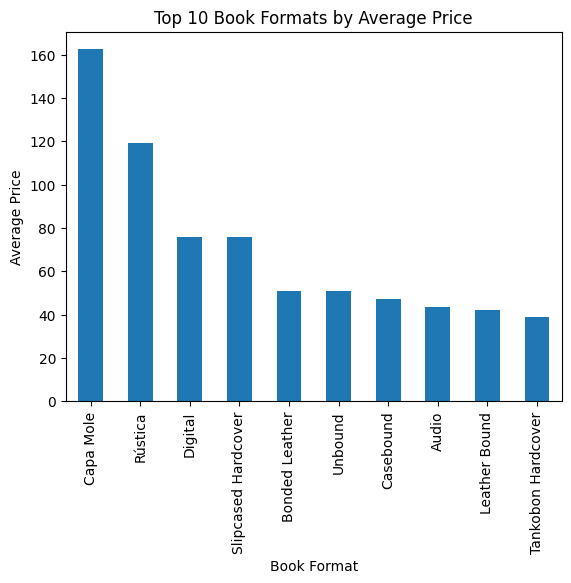

In [26]:
mean_prices = books.groupby('book_format').price.mean()
top_five_mean_prices = mean_prices.nlargest(10)
top_five_mean_prices.plot.bar()
plt.xlabel('Book Format')
plt.ylabel('Average Price')
plt.title('Top 10 Book Formats by Average Price')
plt.show()

Now, let's check the top 10 highest-rated books with more than 10,000 ratings. To do so, we will need to merge data from 'books' and 'ratings_and_bbe_scores' dataframes, likely using the book ID as the common key for merging. We will then filter for books that have both more than 10,000 ratings and a high average rating:

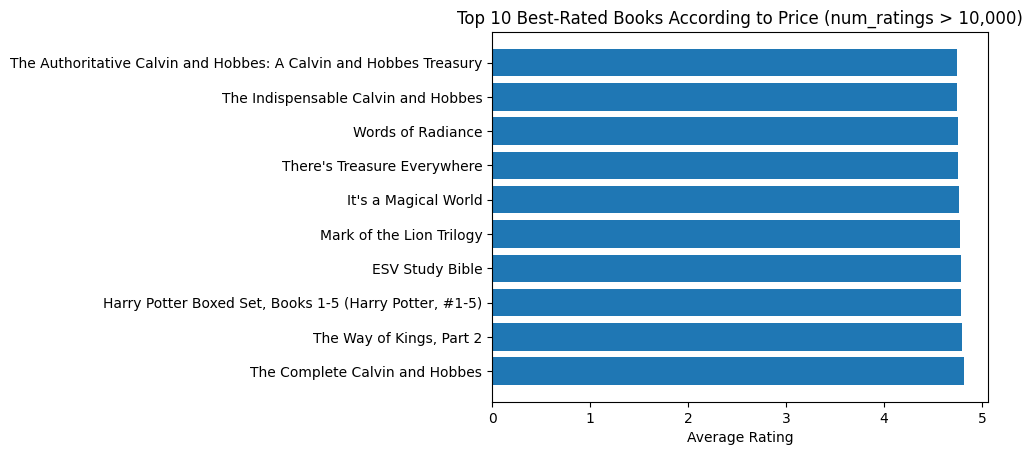

In [27]:
merged_books_ratings = pd.merge(books, ratings_and_bbe_scores, on='book_id')

filtered_books_ratings = merged_books_ratings[merged_books_ratings['num_ratings'] > 10000]
book_analysis = filtered_books_ratings.groupby(['book_id', 'title', 'price']).agg(avg_rating=('rating', 'mean')).reset_index()

sorted_books = book_analysis.sort_values(by=['avg_rating', 'price'], ascending=[False, True])
top_books = sorted_books.head(10)

plt.barh(top_books['title'], top_books['avg_rating'])
plt.xlabel('Average Rating')
plt.title('Top 10 Best-Rated Books According to Price (num_ratings > 10,000)')
plt.show()


## Close the Connection

We free all resources by closing the connection. Remember that it is always important to close connections so that we can avoid unused connections taking up resources:

In [28]:
engine.dispose()

## Conclusion

This short analysis provided a comprehensive understanding of the common and most expensive book formats, as well as the top-rated books based on substantial reader feedback. This information can be valuable for readers, publishers, and market analysts in understanding book preferences and pricing dynamics.

This project showcased effective data processing, transformation, and database management techniques, paving the way for further in-depth analysis.